In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import itertools
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.datasets import load_files       
from keras.utils import np_utils
from glob import glob


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns



C:\Users\manvindr\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#function to load datasets.
def load_dataset(path):
    data = load_files(path)
    X_files = np.array(data['filenames'])
    y_target= np.array(data['target'])
    labels= np.array(data['target_names'])
#     targets = np_utils.to_categorical(np.array(data['target']), 12)
    return X_files,y_target,labels

In [3]:
#function to convert images to 4D tensor
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(128, 128))
    # convert PIL.Image.Image type to 3D tensor with shape (128, 128 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 128, 128, 3) and return 4D tensor
    return np.expand_dims(x, axis=0).astype('float32')/255

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [4]:
# More libs
from tqdm import tqdm
from PIL  import Image
from keras.preprocessing import image
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.optimizers import Adam
from keras.regularizers import *
from keras.applications.inception_v3 import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing import image 
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils


In [5]:
# Path variables
train_dir = './train/'
test_dir = './test/'

In [6]:
from os import listdir
from os.path import isfile, join

In [7]:
# Loading dataset: Files Path and Target class
X, y,labels = load_dataset(train_dir)

In [8]:
y[1], labels[1]

(5, 'Charlock')

### Data Visualization Steps Starts 

In [9]:
#Creating dataframe to hold image height, width along with label and file path. Easy handling for visualization
df_train = []
for labels_id, label in enumerate(labels):
    for file in os.listdir(os.path.join(train_dir, label)):
        img_open = Image.open(os.path.join(train_dir, label,file))
        img_height= img_open.height
        img_width= img_open.width
        df_train.append(['train/{}/{}'.format(label, file), labels_id, label,img_height,img_width])

df_train = pd.DataFrame(df_train, columns=['file', 'labels_id', 'labels','img_height','img_width'])
df_train.shape

(4750, 5)

In [40]:
df_train.head(5)

,file,labels_id,labels,img_height,img_width
0,train/Black-grass/0050f38b3.png,0,Black-grass,196,196
1,train/Black-grass/0183fdf68.png,0,Black-grass,388,388
2,train/Black-grass/0260cffa8.png,0,Black-grass,886,886
3,train/Black-grass/05eedce4d.png,0,Black-grass,117,117
4,train/Black-grass/075d004bc.png,0,Black-grass,471,471


Smallest image  49 x 49


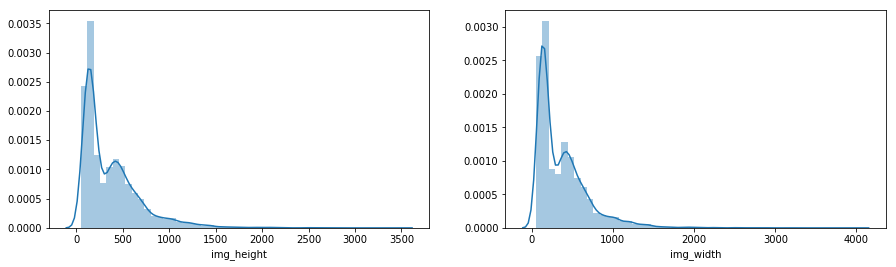

In [11]:
#Image Height, Width Range.
fig, ax =plt.subplots(1,2)
fig.set_size_inches(15,4)
sns.distplot(df_train.img_height,ax=ax[0])
sns.distplot(df_train.img_width,ax=ax[1])
print("Smallest image ", np.min(df_train.img_height), 'x', np.min(df_train.img_width))

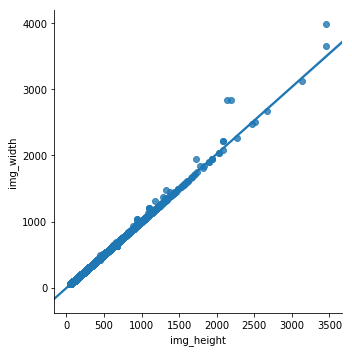

In [14]:
# Checking Aspect Ratio of Images
g = sns.lmplot(x='img_height', y='img_width', data=df_train)

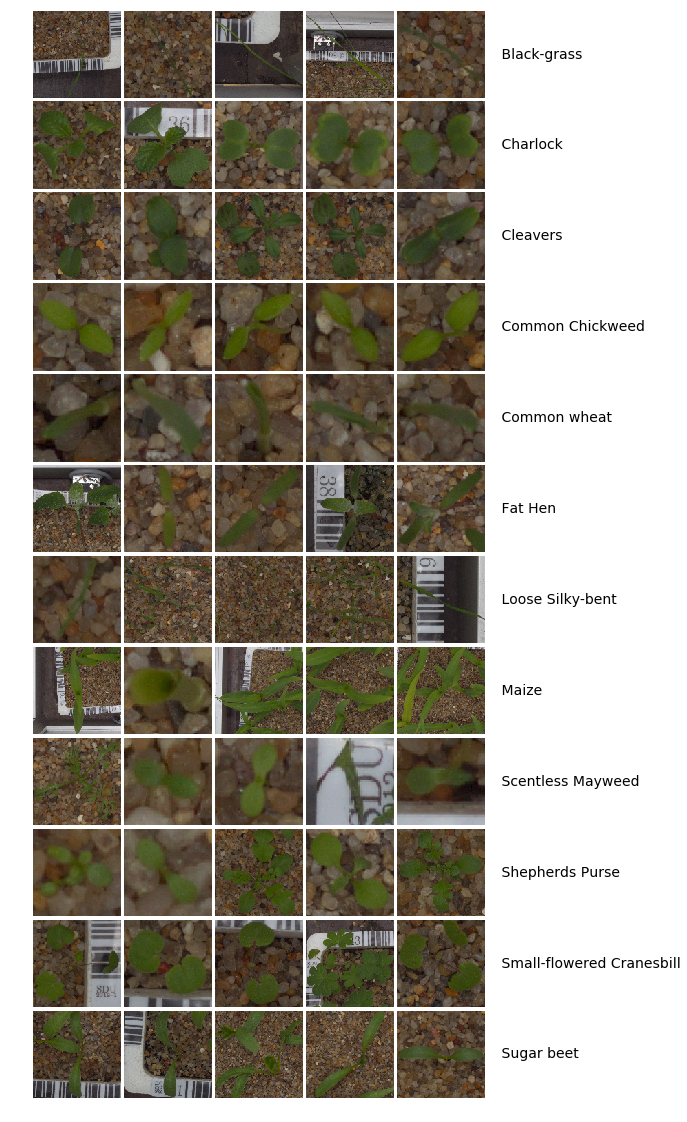

In [15]:
#Plot 5 images from each class of plant. 
fig = plt.figure(1, figsize=(16,20))
grid = ImageGrid(fig, 111, nrows_ncols=(12, 6), axes_pad=0.05)
i = 0
for label_id, label in enumerate(labels):
    j = 0
    for filepath in df_train[df_train['labels'] == label]['file'].values[:5]:
        ax = grid[i]
        img = image.load_img(filepath, target_size=(128, 128))
        img = img.resize((128,128))
        ax.imshow(img)
        ax.axis('off')
        i += 1
        j += 1
        if j > 4:
            ax = grid[i]
            ax.axis('off')
            ax.text(0.5, 0.5, '   '+label, fontsize=14,verticalalignment='center',horizontalalignment='left',transform=ax.transAxes)
            i+=1
            break
        
plt.show();

### Data Visualization Ends

### Data Preprocessing Starts

In [9]:
# Convert Images into 4D Tensor suitable for a Keras CNN
train_tensors = paths_to_tensor(X)
train_labels = y

100%|██████████| 4750/4750 [00:52<00:00, 90.83it/s]


In [10]:
# loading libs
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedShuffleSplit

In [11]:
# Stratified Sampling: Split data in 80% training and 20% for validation and test.
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)     

for train_index, test_index in sss.split(train_tensors, train_labels):
    X_train, X_temp = train_tensors[train_index], train_tensors[test_index]
    y_train, y_temp = train_labels[train_index], train_labels[test_index]

# Split 20% data in validation and Test set
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for train_index, test_index in sss2.split(X_temp, y_temp):
    X_valid, X_test = X_temp[train_index], X_temp[test_index]
    y_valid, y_test = y_temp[train_index], y_temp[test_index]

print(X_train.shape,"-",y_train.shape)
print(X_valid.shape,"-",y_valid.shape)
print(X_test.shape,"-",y_test.shape)


(3800, 128, 128, 3) - (3800,)
(475, 128, 128, 3) - (475,)
(475, 128, 128, 3) - (475,)


In [12]:
#One hot encoding of labels.
y_train_label = np_utils.to_categorical(y_train, 12)
y_valid_label = np_utils.to_categorical(y_valid, 12)
y_test_label = np_utils.to_categorical(y_test, 12)

In [13]:
print(y_train_label.shape)
print(y_valid_label.shape)
print(y_test_label.shape)

(3800, 12)
(475, 12)
(475, 12)


In [14]:
# Function to Plot number of images in each class after spittling
def label_dist(data, title, labels):
    fig, ax = plt.subplots()
    y_pos = np.arange(len(labels))
    data_labels = np.sum(data, axis=0)
    ax.barh(y_pos, data_labels);
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.set_xlabel(title)
    plt.show()

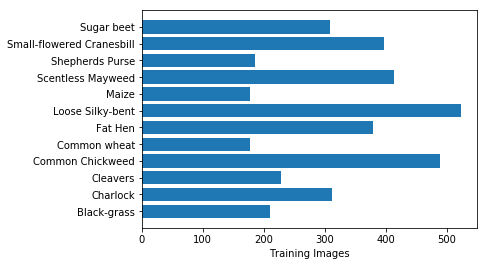

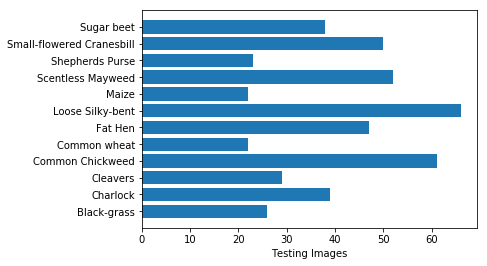

In [23]:
label_dist(y_train_label, 'Training Images', labels)
label_dist(y_test_label, 'Testing Images', labels)

In [15]:
#  Keras doesn't have precision, recall, F1 score inbuilt.
# taken from source code in /keras/metrics.py
import keras.backend as K

def precision(y_true, y_pred): 
    """Precision metric. Only computes a batch-wise average of precision.  
-    Computes the precision, a metric for multi-label classification of 
-    how many selected items are relevant. 
-    """ 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) 
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1))) 
    precision = true_positives / (predicted_positives + K.epsilon()) 
    return precision 

def recall(y_true, y_pred): 
    """Recall metric. 
-    Only computes a batch-wise average of recall. 
-    Computes the recall, a metric for multi-label classification of 
-    how many relevant items are selected. 
-    """ 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) 
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1))) 
    recall = true_positives / (possible_positives + K.epsilon()) 
    return recall 

def fbeta_score(y_true, y_pred, beta=1): 

    """Computes the F score.  
-    The F score is the weighted harmonic mean of precision and recall. 
-    Here it is only computed as a batch-wise average, not globally. 
-    This is useful for multi-label classification, where input samples can be 
-    classified as sets of labels. By only using accuracy (precision) a model 
-    would achieve a perfect score by simply assigning every class to every 
-    input. In order to avoid this, a metric should penalize incorrect class 
-    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0) 
-    computes this, as a weighted mean of the proportion of correct class 
-    assignments vs. the proportion of incorrect class assignments.  
-    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning 
-    correct classes becomes more important, and with beta > 1 the metric is 
-    instead weighted towards penalizing incorrect class assignments. 
-    """ 
    if beta < 0: 
        raise ValueError('The lowest choosable beta is zero (only precision).') 

    # If there are no true positives, fix the F score at 0 like sklearn. 
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0: 

        return 0 
    p = precision(y_true, y_pred) 
    r = recall(y_true, y_pred) 
    bb = beta ** 2 
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon()) 
    return fbeta_score 

def fmeasure(y_true, y_pred): 
    """Computes the f-measure, the harmonic mean of precision and recall. 
    Here it is only computed as a batch-wise average, not globally. 
    """ 
    return fbeta_score(y_true, y_pred, beta=1) 

In [16]:
"""
Train model function:  Take model, epoch, Training Tensors and Labels as argument. Fit the model to training data.

"""
def train(model,model_name, epochs=10, x=X_train, y=y_train_label):
    def get_callbacks(filepath):
        es = EarlyStopping('val_loss', patience=5, mode="min")
        msave = ModelCheckpoint(filepath, save_best_only=True)
        return [es, msave]
    
    file_path = "./weights/weights.from_%s.hdf5" % model_name
    callbacks = get_callbacks(filepath=file_path)
    checkpointer = ModelCheckpoint(filepath=file_path,verbose=1, save_best_only=True)
    history = model.fit(x, y, 
          validation_data=(X_valid, y_valid_label),
          epochs=epochs, batch_size=32, callbacks=callbacks , verbose=1)
    return history

In [17]:
"""
Plot Confusion Matrix. Code taken from 
http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
"""
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
"""
Prediction on test set made from training data
"""
def predict(model,model_name):
    file_path = "./weights/weights.from_%s.hdf5" % model_name
    model.load_weights(file_path)
    predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in X_test]
    test_list = y_test_label.argmax(axis=1)
    f1score=f1_score(test_list, predictions, average='weighted')
    acc = accuracy_score(test_list,predictions)
    print('Test F1 Score: %.5f' % f1score) 
    print('Test Accuracy Score: %.5f' % acc)
    
    #compute confusion matrix
    cnf_matrix = confusion_matrix(test_list, predictions)
    
    # Plot non-normalized confusion matrix
    plt.figure(figsize=(20,10))
    plot_confusion_matrix(cnf_matrix,classes=labels)
    plt.show()
    

In [19]:
"""
 Plot history of training. Show loss decrease after each epoch
https://deeplearningsandbox.com/how-to-use-transfer-learning-and-fine-tuning-in-keras-and-tensorflow-to-build-an-image-recognition-94b0b02444f2
"""
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    fmeasure=history.history['fmeasure']
    val_fmeasure=history.history['val_fmeasure']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    plt.figure(figsize=(10,5))
    plt.plot(epochs, acc, 'g')
    plt.plot(epochs, val_acc, 'b')
    plt.title('Training and validation accuracy')
    plt.legend(['train', 'validtation'], loc='upper left')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()

    
    plt.figure()
    plt.figure(figsize=(10,5))
    plt.plot(epochs, loss, 'g')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training and validation loss')
    plt.legend(['train', 'validtation'], loc='upper left')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()
    
    
    plt.figure()
    plt.figure(figsize=(10,5))
    plt.plot(epochs, fmeasure, 'g')
    plt.plot(epochs, val_fmeasure, 'b')
    plt.title('Training and validation fmeasure')
    plt.legend(['train', 'validtation'], loc='upper left')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()

### BenchMark Model

In [34]:
bench_model = Sequential()
bench_model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(128, 128, 3)))
bench_model.add(MaxPooling2D(pool_size=2))
bench_model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
bench_model.add(MaxPooling2D(pool_size=2))
bench_model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
bench_model.add(MaxPooling2D(pool_size=2))
bench_model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
bench_model.add(MaxPooling2D(pool_size=2))
bench_model.add(Dropout(0.4))
bench_model.add(GlobalAveragePooling2D())
bench_model.add(Dense(12, activation='softmax'))
bench_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 128, 16)      208       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 32)        2080      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        8256      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 64)        16448     
__________

In [35]:
bench_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy',fmeasure])
bench_history=train(bench_model,model_name="benchmark",x = X_train, y = y_train_label, epochs=20)

Train on 3800 samples, validate on 475 samples
Epoch 1/20
3800/3800 [==============================] - 4s - loss: 2.3790 - acc: 0.1829 - fmeasure: 0.0000e+00 - val_loss: 2.2399 - val_acc: 0.2589 - val_fmeasure: 0.0041
Epoch 2/20
3800/3800 [==============================] - 4s - loss: 2.0667 - acc: 0.2771 - fmeasure: 0.0143 - val_loss: 2.0582 - val_acc: 0.2779 - val_fmeasure: 0.0617
Epoch 3/20
3800/3800 [==============================] - 4s - loss: 1.9042 - acc: 0.3153 - fmeasure: 0.0440 - val_loss: 1.8680 - val_acc: 0.3116 - val_fmeasure: 0.1774
Epoch 4/20
3800/3800 [==============================] - 4s - loss: 1.8252 - acc: 0.3413 - fmeasure: 0.1107 - val_loss: 1.7763 - val_acc: 0.3726 - val_fmeasure: 0.1286
Epoch 5/20
3800/3800 [==============================] - 4s - loss: 1.7671 - acc: 0.3587 - fmeasure: 0.1612 - val_loss: 1.8372 - val_acc: 0.3305 - val_fmeasure: 0.1734
Epoch 6/20
3800/3800 [==============================] - 4s - loss: 1.6856 - acc: 0.4071 - fmeasure: 0.2123 - val_l

Test F1 Score: 0.58994
Test Accuracy Score: 0.61263


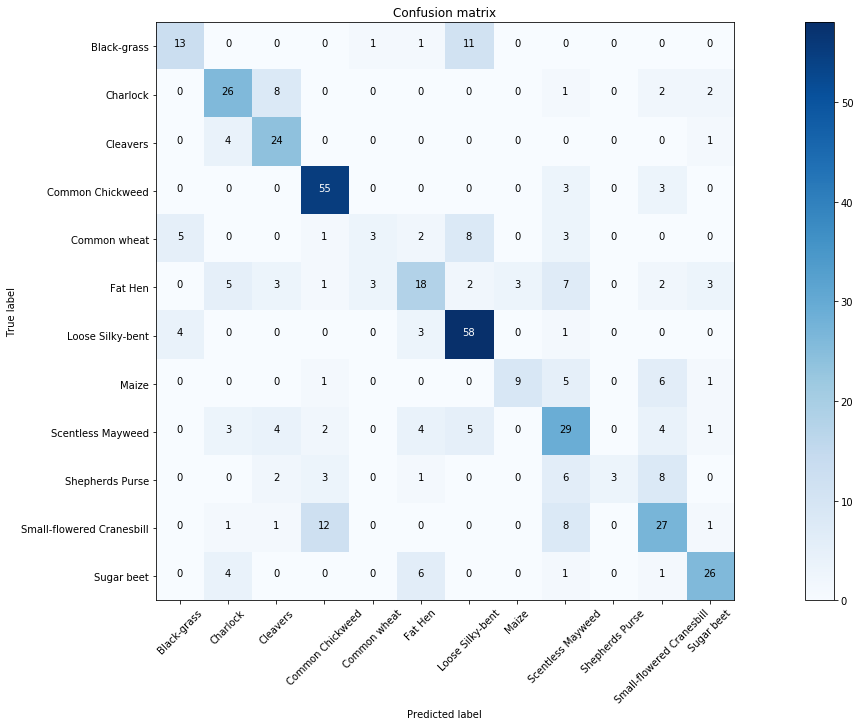

In [36]:
# Predict test set classes and return accuracy and F1 on test data using benchmark model
predict(bench_model,model_name="benchmark")

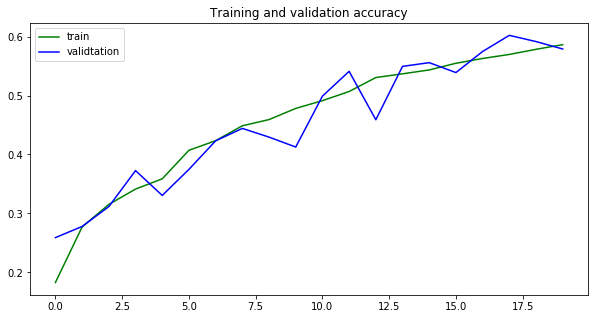

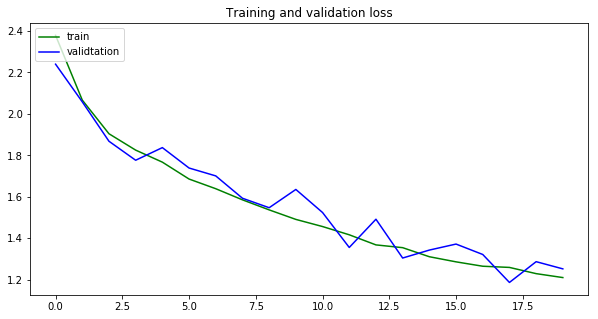

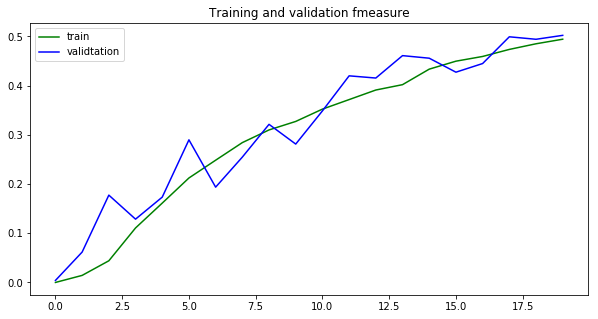

In [56]:
plot_training(bench_history)

In [22]:
import shutil
import random
# Augmentation
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

def augment_imgs(x_train, y_train, labels, n = 1000):
    # empty the augmented folder
    if os.path.isdir('augment3'): 
        shutil.rmtree('augment3')
    os.makedirs('augment3')
    for plant_id in range(12):
        augment_dir = 'augment3/%s' % labels[plant_id]
        os.makedirs(augment_dir)
        imgs = [i for i, j in enumerate(y_train) if j == plant_id]
        #shuffle imgs
        random.shuffle(imgs)
        # make imgs index list to be of length n
#         print(imgs)
        imgs = (imgs * (n // len(imgs))) + imgs[0:n % len(imgs)]    
#         print(imgs)
#         break
        # the .flow() command below generates batches of randomly transformed images
        # and saves the results to the `data/augment` directory
        for batch in datagen.flow(x_train[imgs], batch_size=n, save_to_dir=augment_dir, save_format='png'):
            break

In [23]:
# Once images augmented. comment this to save time
# augment_imgs(X_train, y_train, labels)

100%|██████████| 12000/12000 [00:12<00:00, 956.69it/s]


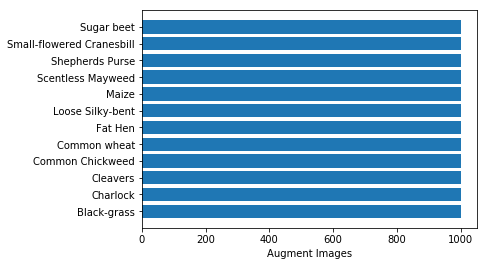

In [24]:
# Prepare Augment images for Keras
X_train_aug, y_train_aug,labels_aug = load_dataset('augment3')

#Convert to tensor
X_train_aug_tensor = paths_to_tensor(X_train_aug)

# One hot encoding of labels
y_train_aug_label = np_utils.to_categorical(y_train_aug, 12)

label_dist(y_train_aug_label, 'Augment Images', labels_aug)

In [67]:
#Same architect as benchmark model on augmented data
aug_model = Sequential()
aug_model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(128, 128, 3)))
aug_model.add(MaxPooling2D(pool_size=2))
aug_model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
aug_model.add(MaxPooling2D(pool_size=2))
aug_model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
aug_model.add(MaxPooling2D(pool_size=2))
aug_model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
aug_model.add(MaxPooling2D(pool_size=2))
aug_model.add(Dropout(0.4))
aug_model.add(GlobalAveragePooling2D())
aug_model.add(Dense(12, activation='softmax'))
aug_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 128, 128, 16)      208       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 64, 64, 32)        2080      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 32, 32, 64)        8256      
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 16, 16, 64)        16448     
__________

In [68]:
# Same architect as benchmark but data augmented.
aug_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy',fmeasure])
aug_history=train(aug_model,model_name="aug_model",x = X_train_aug_tensor, y = y_train_aug_label, epochs=20)

Train on 7200 samples, validate on 475 samples
Epoch 1/20
7200/7200 [==============================] - 8s - loss: 2.3656 - acc: 0.1374 - fmeasure: 5.3872e-04 - val_loss: 2.1523 - val_acc: 0.2547 - val_fmeasure: 0.0000e+00
Epoch 2/20
7200/7200 [==============================] - 7s - loss: 1.9810 - acc: 0.2564 - fmeasure: 0.0229 - val_loss: 2.0127 - val_acc: 0.2821 - val_fmeasure: 0.0236
Epoch 3/20
7200/7200 [==============================] - 7s - loss: 1.8621 - acc: 0.3115 - fmeasure: 0.0526 - val_loss: 1.9585 - val_acc: 0.2421 - val_fmeasure: 0.0397
Epoch 4/20
7200/7200 [==============================] - 7s - loss: 1.7008 - acc: 0.3868 - fmeasure: 0.1168 - val_loss: 1.7910 - val_acc: 0.3789 - val_fmeasure: 0.0978
Epoch 5/20
7200/7200 [==============================] - 7s - loss: 1.5730 - acc: 0.4412 - fmeasure: 0.2209 - val_loss: 1.7456 - val_acc: 0.4295 - val_fmeasure: 0.1780
Epoch 6/20
7200/7200 [==============================] - 7s - loss: 1.4702 - acc: 0.4803 - fmeasure: 0.3167 - v

Test F1 Score: 0.60812
Test Accuracy Score: 0.61684


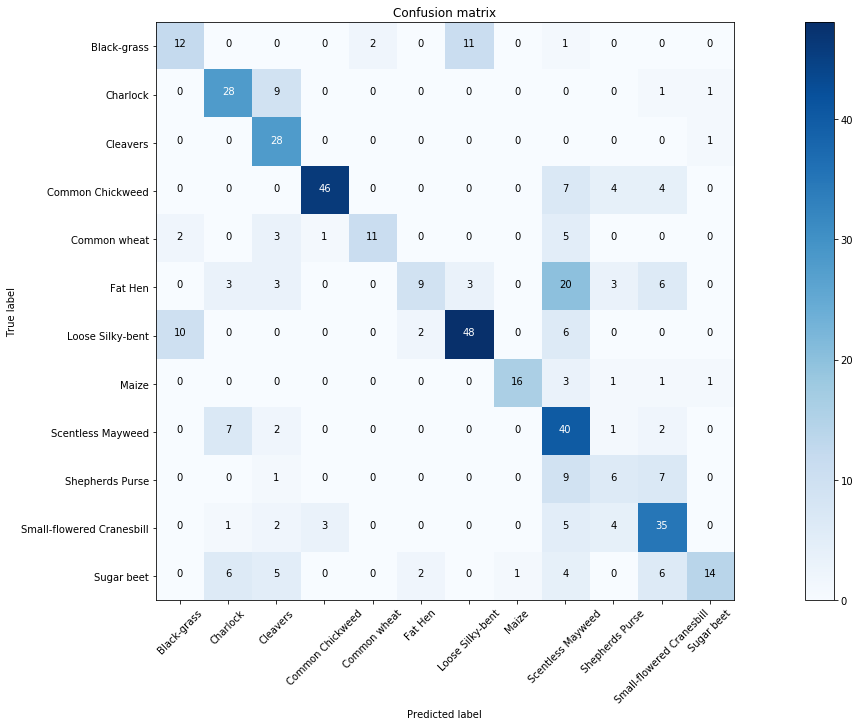

In [69]:
predict(aug_model,model_name="aug_model")

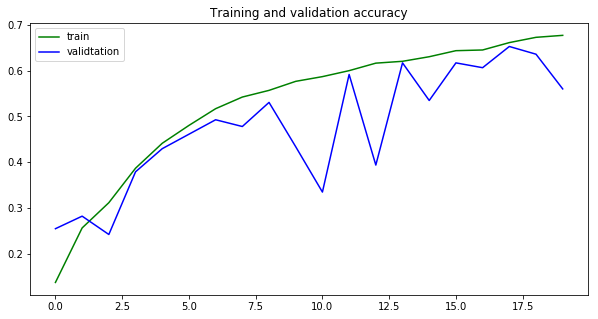

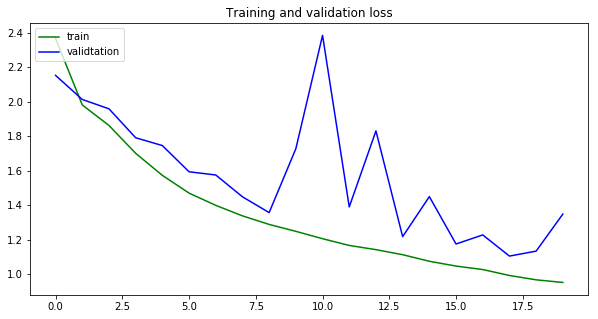

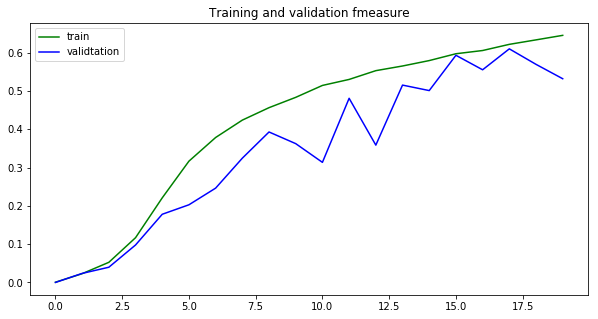

In [70]:
plot_training(aug_history)

In [72]:
# Same architect as benchmark but data augmented and change optimizer
aug_adam_model = Sequential()
aug_adam_model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(128, 128, 3)))
aug_adam_model.add(MaxPooling2D(pool_size=2))
aug_adam_model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
aug_adam_model.add(MaxPooling2D(pool_size=2))
aug_adam_model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
aug_adam_model.add(MaxPooling2D(pool_size=2))
aug_adam_model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
aug_adam_model.add(MaxPooling2D(pool_size=2))
aug_adam_model.add(Dropout(0.4))
aug_adam_model.add(GlobalAveragePooling2D())
aug_adam_model.add(Dense(12, activation='softmax'))
aug_adam_model.summary()
aug_adam_model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy',fmeasure])
aug_adam_history=train(aug_adam_model,model_name="aug_adam_model",x = X_train_aug_tensor, y = y_train_aug_label, epochs=20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 128, 128, 16)      208       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 64, 64, 32)        2080      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 32, 32, 64)        8256      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 16, 16, 64)        16448     
__________

Test F1 Score: 0.54694
Test Accuracy Score: 0.54947


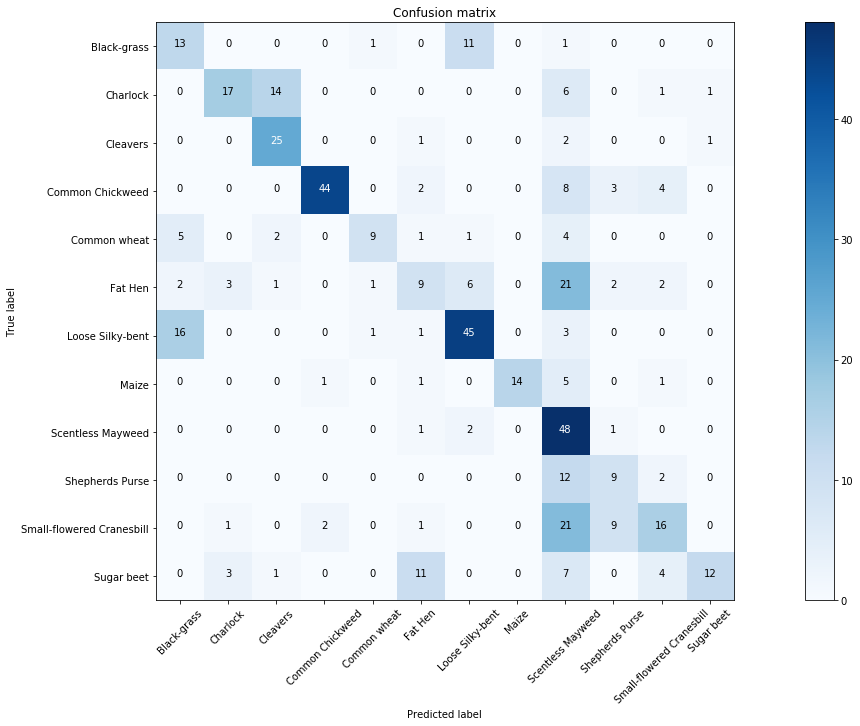

In [74]:
predict(aug_adam_model,model_name="aug_adam_model")

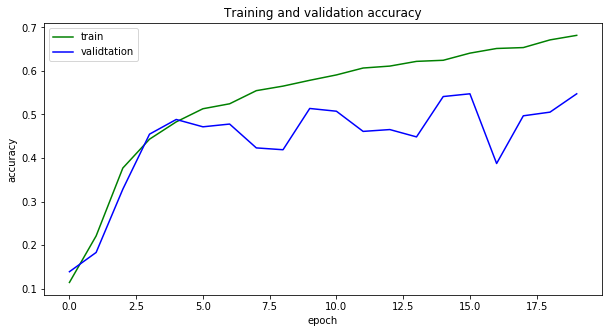

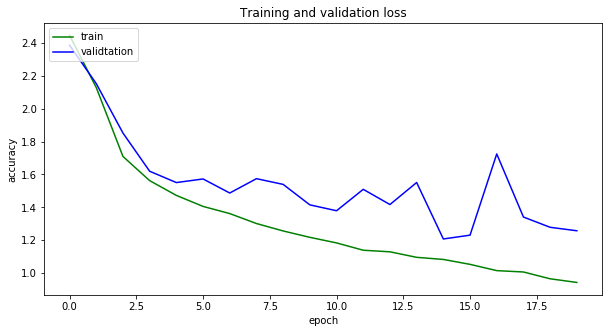

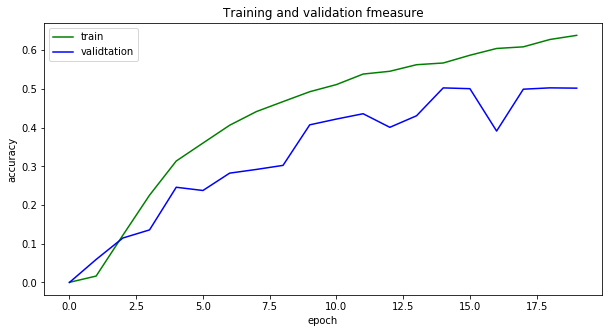

In [76]:
plot_training(aug_adam_history)

#### Model 2
#### 1. Adding fully connected layer to make it dense

In [77]:
#Model Name in Report: DenseFC1 with RMSProp
model2 = Sequential()
model2.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(128, 128, 3)))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Dropout(0.4))
model2.add(GlobalAveragePooling2D())
model2.add(Dense(512,activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(256,activation='relu'))
model2.add(Dropout(0.4))
model2.add(Dense(12, activation='softmax'))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 128, 128, 16)      208       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 64, 64, 32)        2080      
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 32, 32, 64)        8256      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 16, 16, 64)        16448     
__________

In [78]:
# Dense layer added
model2.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy',fmeasure])
model2_history=train(model2,model_name="denseFC1",x = X_train_aug_tensor, y = y_train_aug_label, epochs=20)

Train on 7200 samples, validate on 475 samples
Epoch 1/20
7200/7200 [==============================] - 8s - loss: 2.3407 - acc: 0.1428 - fmeasure: 0.0013 - val_loss: 2.0809 - val_acc: 0.1495 - val_fmeasure: 0.0000e+00
Epoch 2/20
7200/7200 [==============================] - 8s - loss: 1.9883 - acc: 0.2304 - fmeasure: 0.0173 - val_loss: 2.0630 - val_acc: 0.1811 - val_fmeasure: 0.0000e+00
Epoch 3/20
7200/7200 [==============================] - 8s - loss: 1.8101 - acc: 0.3150 - fmeasure: 0.0707 - val_loss: 1.9337 - val_acc: 0.2695 - val_fmeasure: 0.0806
Epoch 4/20
7200/7200 [==============================] - 8s - loss: 1.6023 - acc: 0.4033 - fmeasure: 0.1890 - val_loss: 1.6650 - val_acc: 0.3747 - val_fmeasure: 0.1927
Epoch 5/20
7200/7200 [==============================] - 8s - loss: 1.4726 - acc: 0.4581 - fmeasure: 0.3008 - val_loss: 1.5218 - val_acc: 0.4400 - val_fmeasure: 0.2776
Epoch 6/20
7200/7200 [==============================] - 8s - loss: 1.3788 - acc: 0.4890 - fmeasure: 0.3796 - v

Test F1 Score: 0.64369
Test Accuracy Score: 0.64842


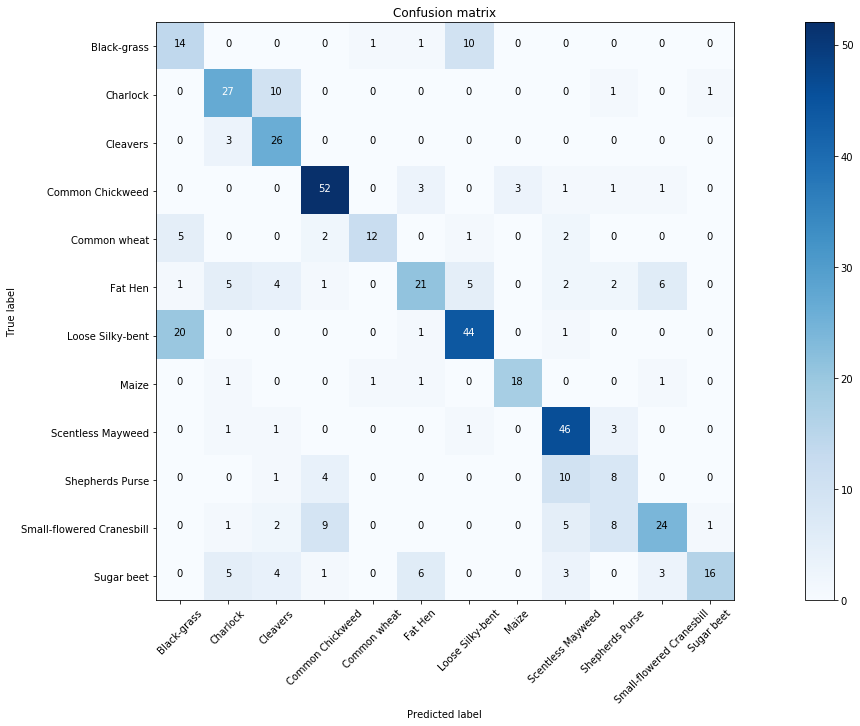

In [79]:
predict(model2,model_name="denseFC1")

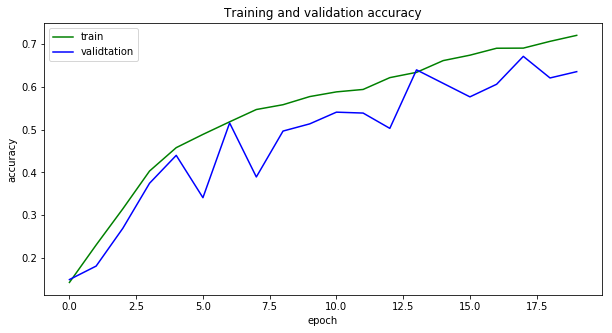

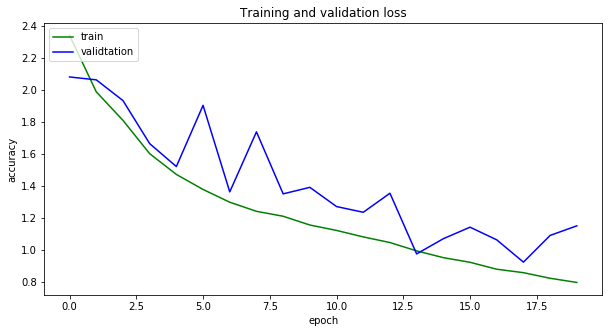

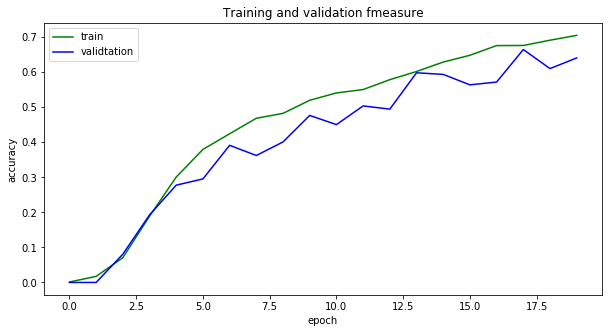

In [80]:
plot_training(model2_history)

In [81]:
# Model 2 with optimizer change 
# #Model Name in Report: DenseFC1 with Adam
model3 = Sequential()
model3.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(128, 128, 3)))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.4))
model3.add(GlobalAveragePooling2D())
model3.add(Dense(512,activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(256,activation='relu'))
model3.add(Dropout(0.4))
model3.add(Dense(12, activation='softmax'))
model3.summary()
# Dense layer added
model3.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy',fmeasure])
model3_history=train(model3,model_name="denseFC1_Adam",x = X_train_aug_tensor, y = y_train_aug_label, epochs=20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 128, 128, 16)      208       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 64, 64, 32)        2080      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 32, 32, 64)        8256      
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 16, 16, 64)        16448     
__________

Test F1 Score: 0.64674
Test Accuracy Score: 0.64842


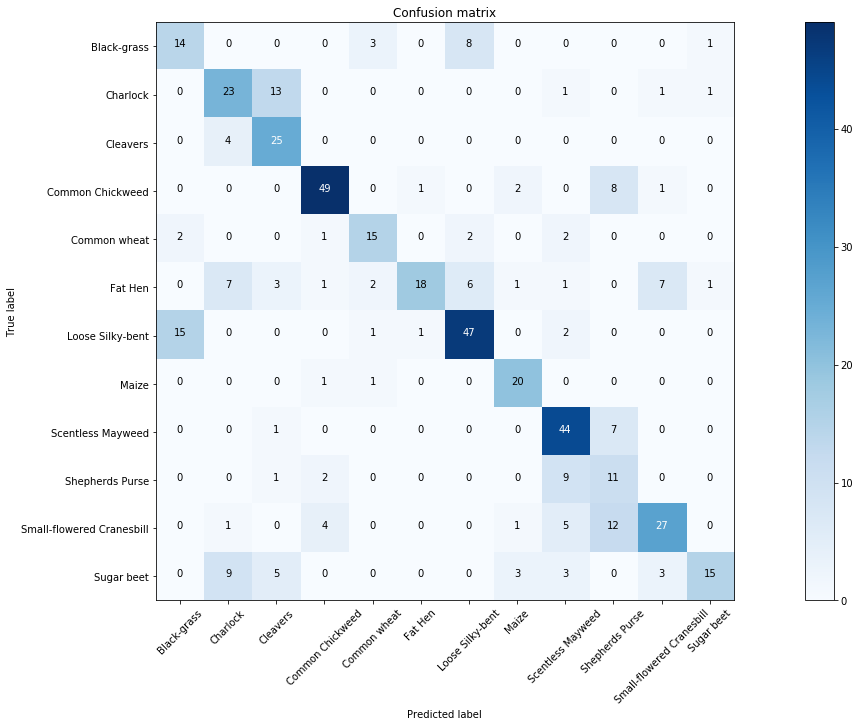

In [82]:
predict(model3,model_name="denseFC1_Adam")

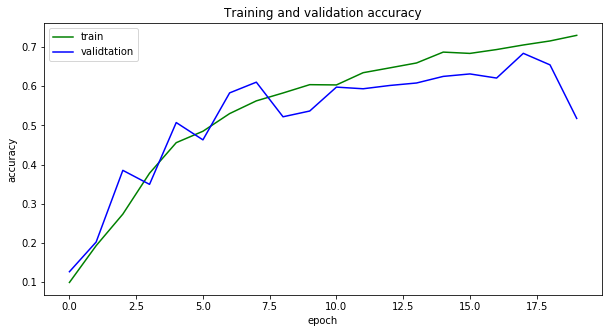

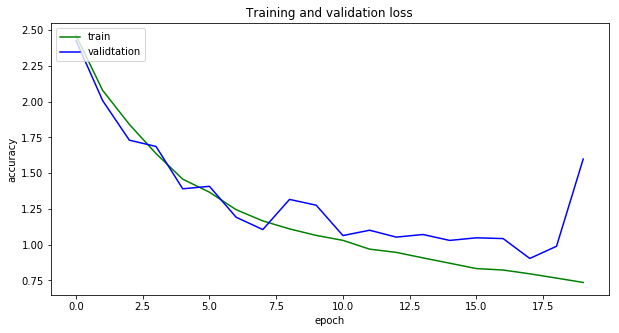

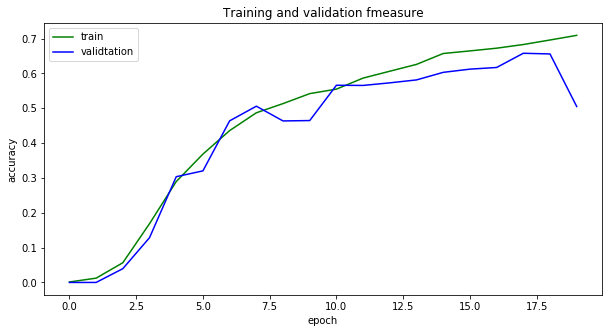

In [83]:
plot_training(model3_history)

In [97]:

# Change Conv structure
# #Model Name in Report: Wide2
model4=Sequential()
#Conv Layer 1
model4.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding='same', input_shape=(128, 128, 3)))
model4.add(MaxPooling2D(pool_size=(3, 3)))
model4.add(Dropout(0.2))

#Conv Layer 2
model4.add(Conv2D(128, kernel_size=(3, 3),padding='same', activation='relu' ))
model4.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model4.add(Dropout(0.2))

#Conv Layer 3
model4.add(Conv2D(128, kernel_size=(3, 3),padding='same', activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model4.add(Dropout(0.2))

#Conv Layer 4
model4.add(Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model4.add(GlobalAveragePooling2D())

#Dense Layers
model4.add(Dense(512, activation='relu'))
model4.add(Dropout(0.2))

#Dense Layer 2
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.2))

model4.add(Dense(12, activation='softmax'))
model4.summary()
# Dense layer added
model4.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy',fmeasure])
model4_history=train(model4,model_name="Wide2",x = X_train_aug_tensor, y = y_train_aug_label, epochs=20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 42, 42, 64)        0         
_________________________________________________________________
dropout_55 (Dropout)         (None, 42, 42, 64)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 42, 42, 128)       73856     
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 21, 21, 128)       0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 21, 21, 128)       0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 21, 21, 128)       147584    
__________

Test F1 Score: 0.81633
Test Accuracy Score: 0.80632


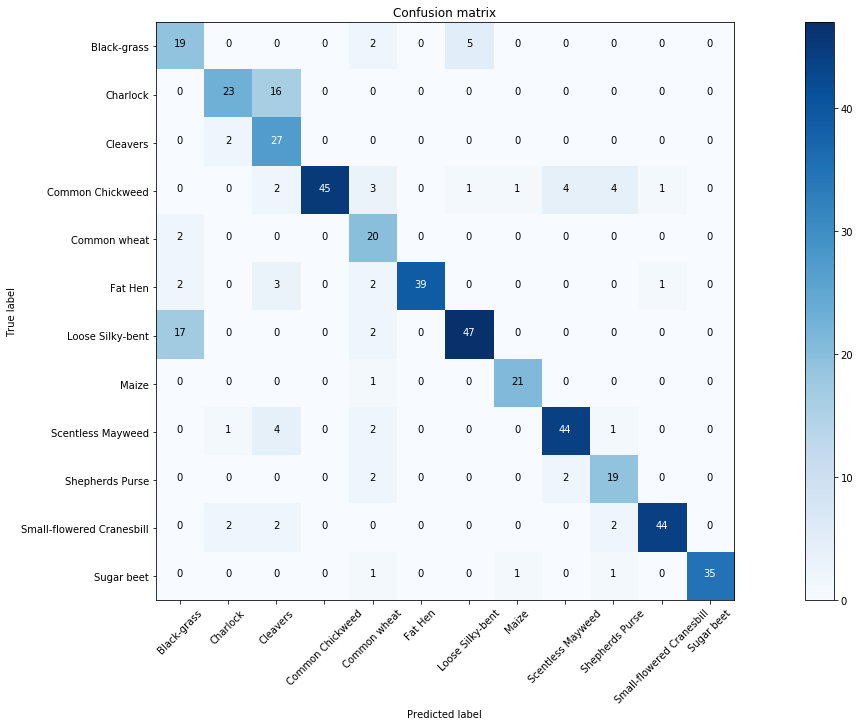

In [98]:
predict(model4,model_name="Wide2")

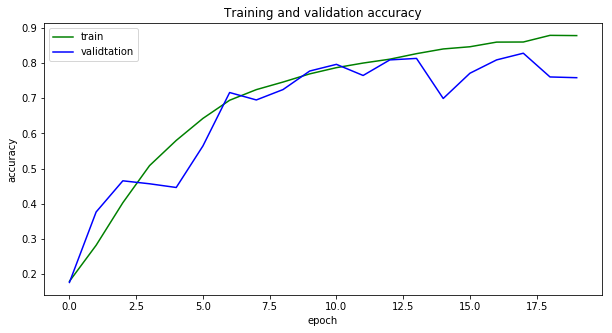

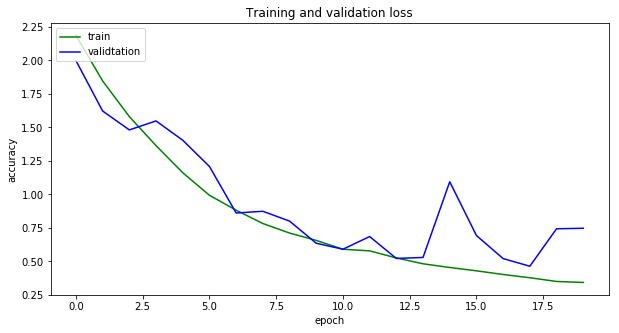

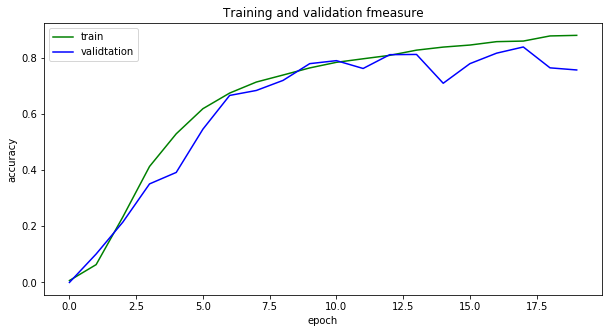

In [99]:
plot_training(model4_history)

In [100]:
# Model Name in Report:  Wide2Dense
# Added more nodes to fullyconnected layers

model5=Sequential()
#Conv Layer 1
model5.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding='same', input_shape=(128, 128, 3)))
model5.add(MaxPooling2D(pool_size=(3, 3)))
model5.add(Dropout(0.2))

#Conv Layer 2
model5.add(Conv2D(128, kernel_size=(3, 3),padding='same', activation='relu' ))
model5.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model5.add(Dropout(0.2))

#Conv Layer 3
model5.add(Conv2D(128, kernel_size=(3, 3),padding='same', activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model5.add(Dropout(0.2))

#Conv Layer 4
model5.add(Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu'))
model5.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model5.add(GlobalAveragePooling2D())

#Dense Layers
model5.add(Dense(1024, activation='relu'))
model5.add(Dropout(0.2))

#Dense Layer 2
model5.add(Dense(512, activation='relu'))
model5.add(Dropout(0.2))

model5.add(Dense(12, activation='softmax'))
model5.summary()
# Dense layer added
model5.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy',fmeasure])
model5_history=train(model5,model_name="conv2_dense",x = X_train_aug_tensor, y = y_train_aug_label, epochs=20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_91 (MaxPooling (None, 42, 42, 64)        0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 42, 42, 64)        0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 42, 42, 128)       73856     
_________________________________________________________________
max_pooling2d_92 (MaxPooling (None, 21, 21, 128)       0         
_________________________________________________________________
dropout_61 (Dropout)         (None, 21, 21, 128)       0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 21, 21, 128)       147584    
__________

Test F1 Score: 0.81404
Test Accuracy Score: 0.81263


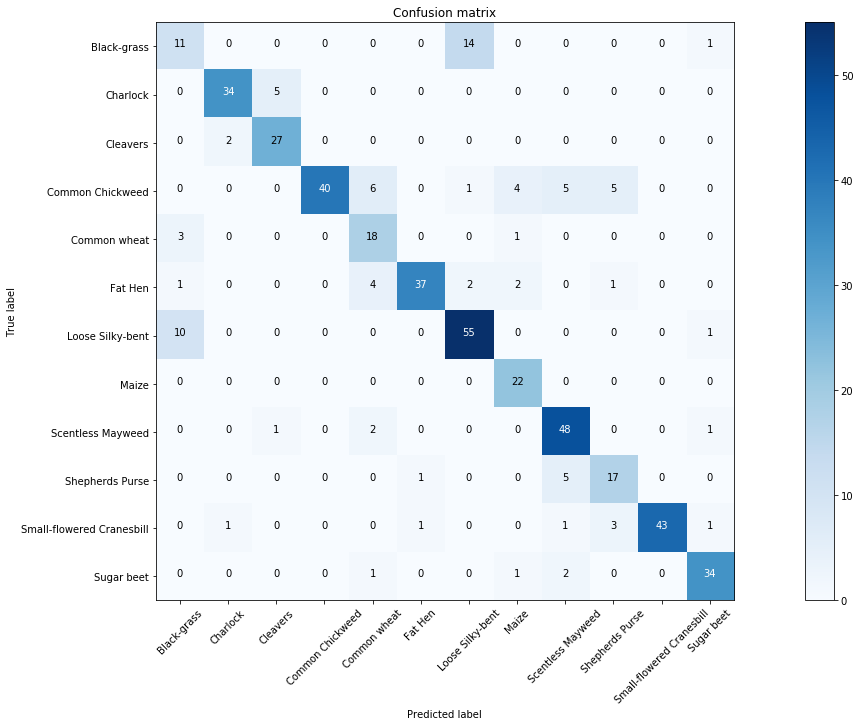

In [101]:
predict(model5,model_name="conv2_dense")

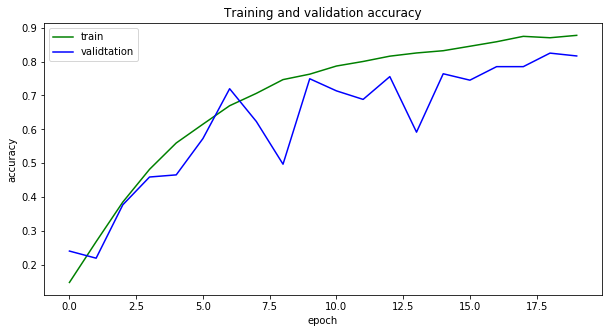

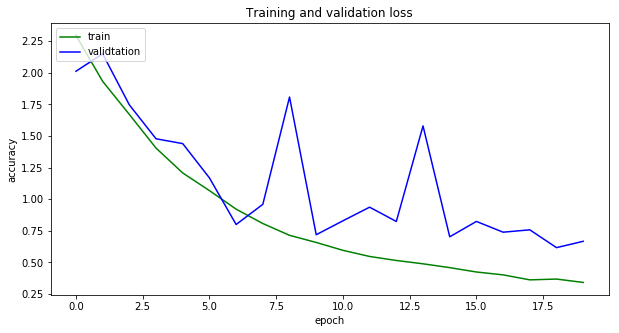

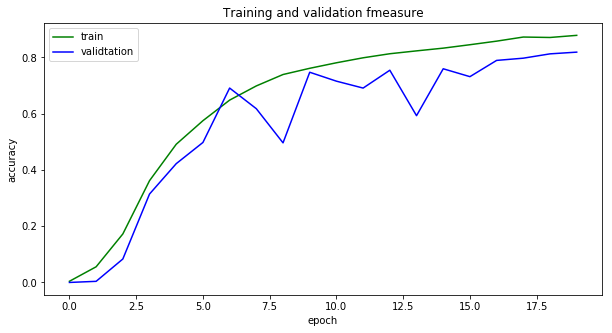

In [102]:
plot_training(model5_history)

In [103]:
# Kernel Size model Wide2 change to 2,2
# Model Name in Report: Wide2( kernel size 2)
model6=Sequential()
#Conv Layer 1
model6.add(Conv2D(64, kernel_size=(2, 2),activation='relu',padding='same', input_shape=(128, 128, 3)))
model6.add(MaxPooling2D(pool_size=(3, 3)))
model6.add(Dropout(0.2))

#Conv Layer 2
model6.add(Conv2D(128, kernel_size=(2, 2),padding='same', activation='relu' ))
model6.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model6.add(Dropout(0.2))

#Conv Layer 3
model6.add(Conv2D(128, kernel_size=(2, 2),padding='same', activation='relu'))
model6.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model6.add(Dropout(0.2))

#Conv Layer 4
model6.add(Conv2D(64, kernel_size=(2, 2),padding='same', activation='relu'))
model6.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model6.add(GlobalAveragePooling2D())

#Dense Layers
model6.add(Dense(512, activation='relu'))
model6.add(Dropout(0.2))

#Dense Layer 2
model6.add(Dense(256, activation='relu'))
model6.add(Dropout(0.2))

model6.add(Dense(12, activation='softmax'))
model6.summary()
# Dense layer added
model6.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy',fmeasure])
model6_history=train(model6,model_name="conv2_Kernel",x = X_train_aug_tensor, y = y_train_aug_label, epochs=20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 128, 128, 64)      832       
_________________________________________________________________
max_pooling2d_95 (MaxPooling (None, 42, 42, 64)        0         
_________________________________________________________________
dropout_65 (Dropout)         (None, 42, 42, 64)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 42, 42, 128)       32896     
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 21, 21, 128)       0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 21, 21, 128)       0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 21, 21, 128)       65664     
__________

Test F1 Score: 0.63500
Test Accuracy Score: 0.63579


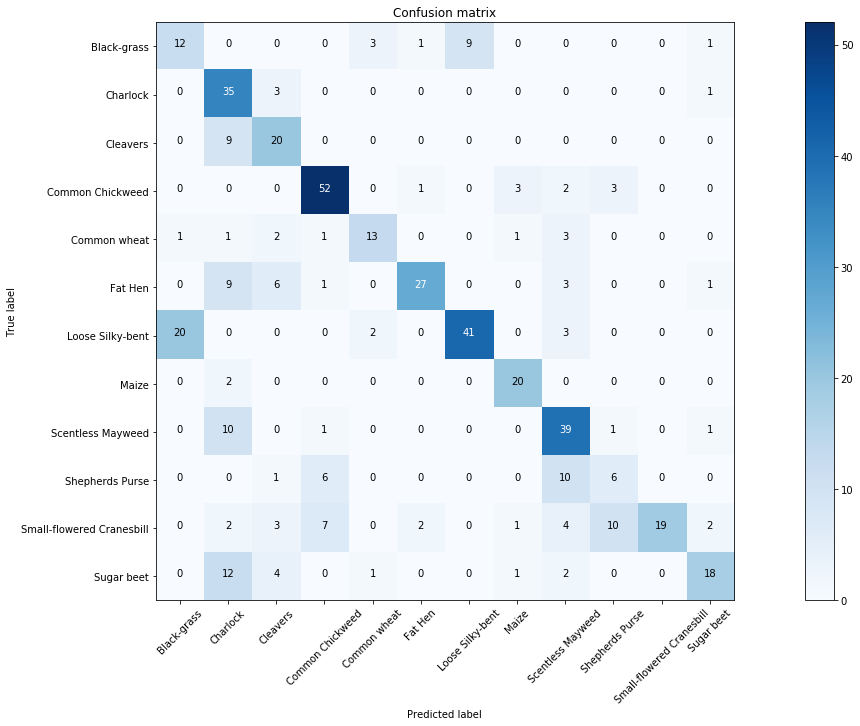

In [104]:
predict(model6,model_name="conv2_Kernel")

In [105]:
# Model Name in Report: Wide2( kernel size 3)
model7=Sequential()
#Conv Layer 1
model7.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding='same', input_shape=(128, 128, 3)))
model7.add(MaxPooling2D(pool_size=(3, 3)))
model7.add(Dropout(0.2))

#Conv Layer 2
model7.add(Conv2D(128, kernel_size=(3, 3),padding='same', activation='relu' ))
model7.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model7.add(Dropout(0.2))

#Conv Layer 3
model7.add(Conv2D(128, kernel_size=(3, 3),padding='same', activation='relu'))
model7.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model7.add(Dropout(0.2))

#Conv Layer 4
model7.add(Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu'))
model7.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model7.add(GlobalAveragePooling2D())

#Dense Layers
model7.add(Dense(512, activation='relu'))
model7.add(Dropout(0.2))

#Dense Layer 2
model7.add(Dense(256, activation='relu'))
model7.add(Dropout(0.2))

model7.add(Dense(12, activation='softmax'))
model7.summary()
# Dense layer added
model7.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['accuracy',fmeasure])
model7_history=train(model7,model_name="conv2_Adam",x = X_train_aug_tensor, y = y_train_aug_label, epochs=20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_102 (Conv2D)          (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 42, 42, 64)        0         
_________________________________________________________________
dropout_70 (Dropout)         (None, 42, 42, 64)        0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 42, 42, 128)       73856     
_________________________________________________________________
max_pooling2d_100 (MaxPoolin (None, 21, 21, 128)       0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 21, 21, 128)       0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 21, 21, 128)       147584    
__________

Test F1 Score: 0.76687
Test Accuracy Score: 0.76421


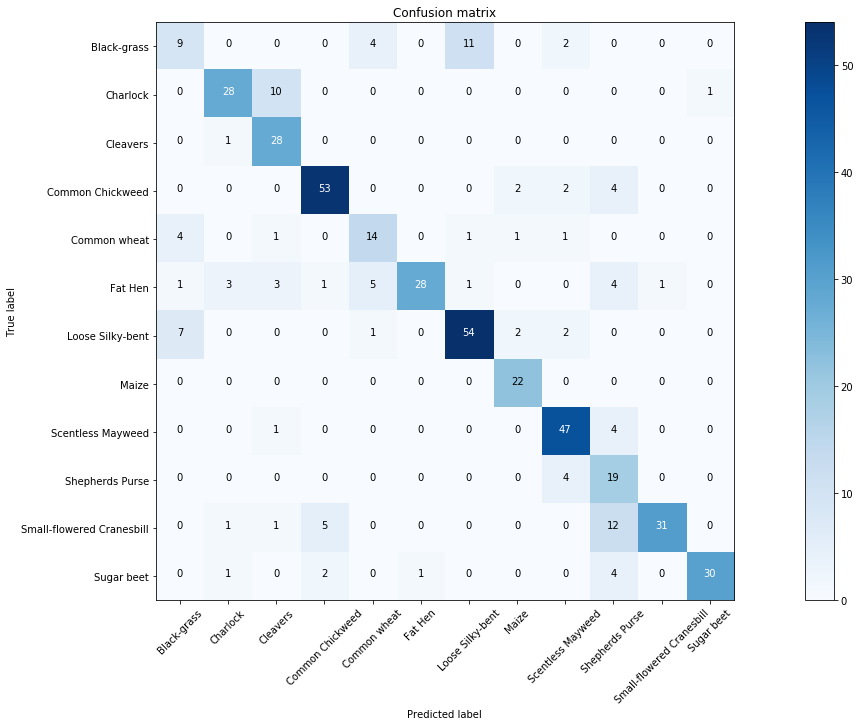

In [107]:
predict(model7,model_name="conv2_Adam")

In [112]:
# Model Wide2 : decrease number of filter, increase nodes in fully connected layer
#Model Name: Wide2_FNN

model8=Sequential()
#Conv Layer 1
model8.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding='same', input_shape=(128, 128, 3)))
model8.add(MaxPooling2D(pool_size=(3, 3)))
model8.add(Dropout(0.2))

#Conv Layer 2
model8.add(Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu' ))
model8.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model8.add(Dropout(0.2))

#Conv Layer 3
model8.add(Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu'))
model8.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model8.add(Dropout(0.2))

#Conv Layer 4
model8.add(Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu'))
model8.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model8.add(GlobalAveragePooling2D())

#Dense Layers
model8.add(Dense(1024, activation='relu'))
model8.add(Dropout(0.2))

#Dense Layer 2
model8.add(Dense(512, activation='relu'))
model8.add(Dropout(0.2))

model8.add(Dense(12, activation='softmax'))
model8.summary()
# Dense layer added
model8.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy',fmeasure])
model8_history=train(model8,model_name="conv2_Filter_Dense",x = X_train_aug_tensor, y = y_train_aug_label, epochs=20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_110 (Conv2D)          (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_107 (MaxPoolin (None, 42, 42, 32)        0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 42, 42, 32)        0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 42, 42, 64)        18496     
_________________________________________________________________
max_pooling2d_108 (MaxPoolin (None, 21, 21, 64)        0         
_________________________________________________________________
dropout_81 (Dropout)         (None, 21, 21, 64)        0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 21, 21, 64)        36928     
__________

Test F1 Score: 0.79241
Test Accuracy Score: 0.78526


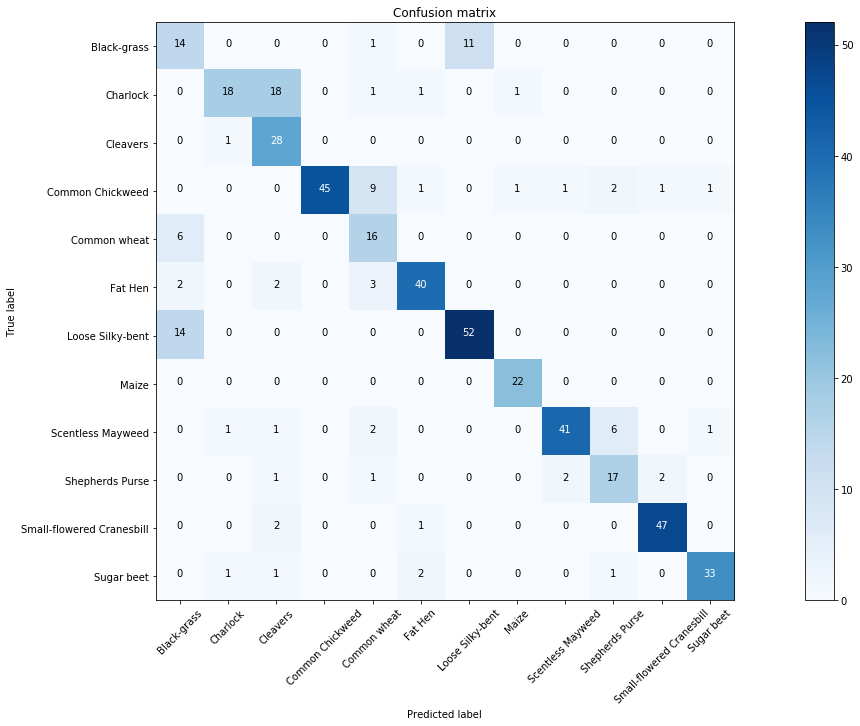

In [113]:
predict(model8,model_name="conv2_Filter_Dense")

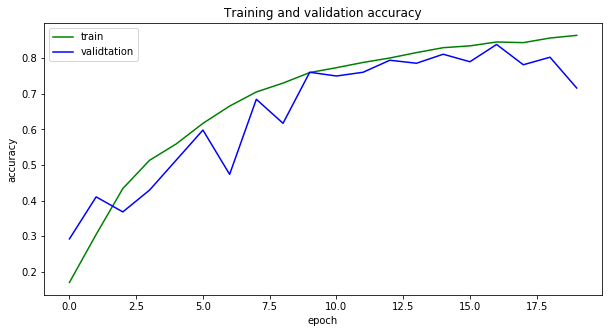

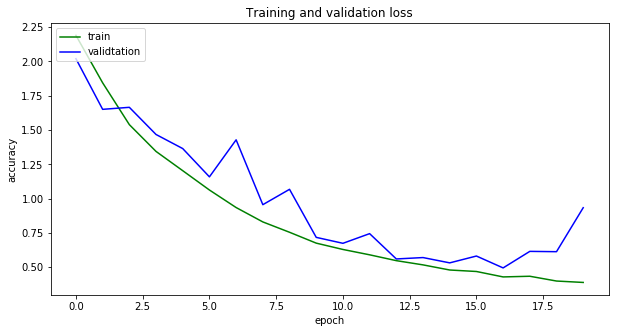

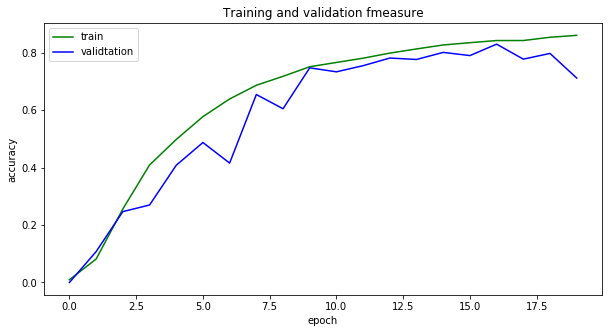

In [114]:
plot_training(model8_history)

In [20]:
#Change architect by introducting additional Conv layer before max pooling.
#Model Name in Report : Wide2_Extra_Conv

model9=Sequential()
#Conv Layer 1
model9.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding='same', input_shape=(128, 128, 3)))
model9.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding='same'))
model9.add(MaxPooling2D(pool_size=(3, 3)))
model9.add(Dropout(0.2))

#Conv Layer 2
model9.add(Conv2D(128, kernel_size=(3, 3),padding='same', activation='relu' ))
model9.add(Conv2D(128, kernel_size=(3, 3),padding='same', activation='relu' ))
model9.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model9.add(Dropout(0.2))

#Conv Layer 3
model9.add(Conv2D(128, kernel_size=(3, 3),padding='same', activation='relu'))
model9.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model9.add(Dropout(0.2))

#Conv Layer 4
model9.add(Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu'))
model9.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model9.add(GlobalAveragePooling2D())

#Dense Layer 
model9.add(Dense(512, activation='relu'))
model9.add(Dropout(0.4))

#Dense Layer 
model9.add(Dense(256, activation='relu'))
model9.add(Dropout(0.4))

model9.add(Dense(12, activation='softmax'))
model9.summary()
# Dense layer added
model9.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy',fmeasure])
model9_history=train(model9,model_name="conv_conv2_model5_epoch",x = X_train_aug_tensor, y = y_train_aug_label, epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 42, 42, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 42, 42, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 42, 42, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 128)       0         
__________

Test F1 Score: 0.84094
Test Accuracy Score: 0.83579


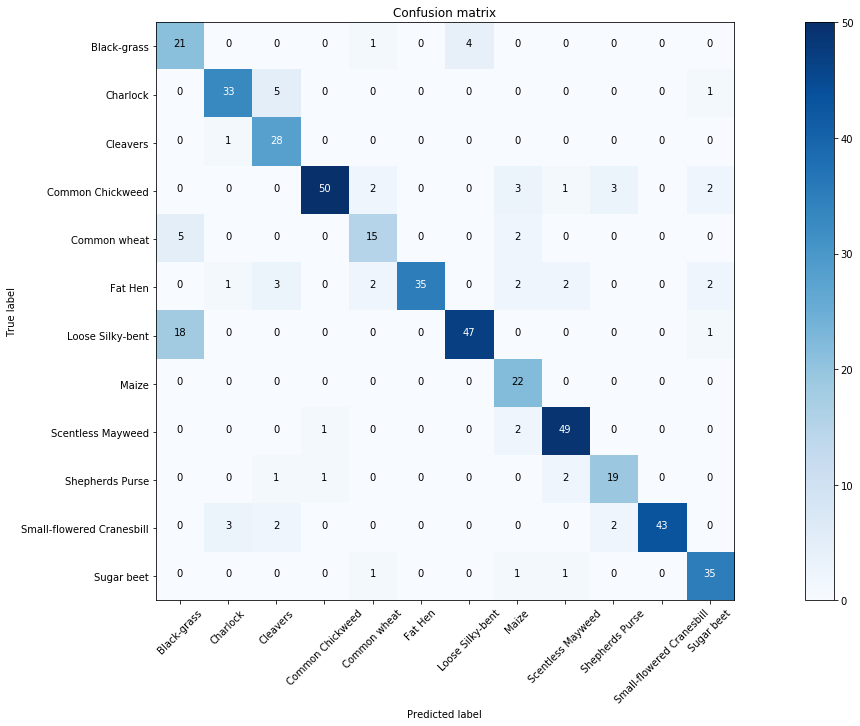

In [123]:
predict(model9,model_name="conv2_model5_epoch")

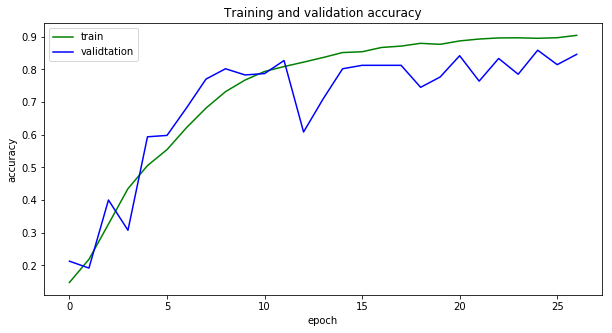

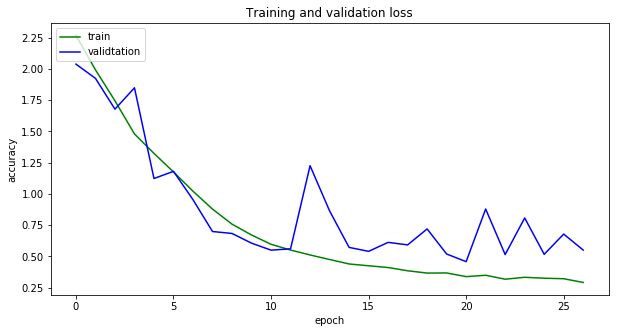

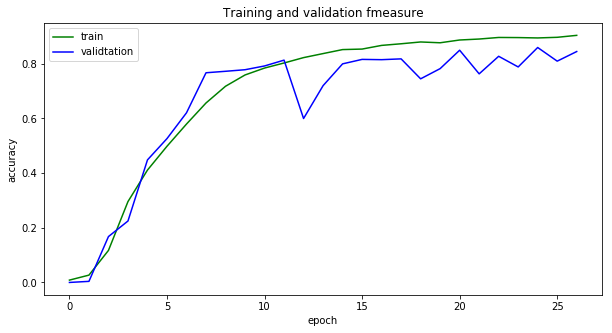

In [124]:
plot_training(model9_history)

In [54]:
# Transfer Learning and Fine tuning
from keras.applications.xception import Xception

In [45]:
# IncpetionV3: Transfer Learning
model_Xception = Xception(weights = "imagenet", include_top=False, input_shape = (128, 128, 3))

#freeze layer weight
for layer in model_Xception.layers:
    layer.trainable = False

# add FC layers
x = model_Xception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(12, activation='softmax')(x)
model_Xception = Model(inputs=model_Xception.input, outputs=predictions)
model_Xception.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy',fmeasure]) 
    

In [46]:
Xception_history=train(model_Xception,model_name="Xception",x = X_train_aug_tensor, y = y_train_aug_label, epochs=50)

Train on 7200 samples, validate on 475 samples
Epoch 1/50
7200/7200 [==============================] - 40s - loss: 1.9297 - acc: 0.3842 - fmeasure: 0.1708 - val_loss: 2.0274 - val_acc: 0.3537 - val_fmeasure: 0.0889
Epoch 2/50
7200/7200 [==============================] - 28s - loss: 1.5060 - acc: 0.5357 - fmeasure: 0.3851 - val_loss: 1.9624 - val_acc: 0.3747 - val_fmeasure: 0.1430
Epoch 3/50
7200/7200 [==============================] - 28s - loss: 1.3197 - acc: 0.5818 - fmeasure: 0.4860 - val_loss: 1.9530 - val_acc: 0.3516 - val_fmeasure: 0.1297
Epoch 4/50
7200/7200 [==============================] - 28s - loss: 1.2264 - acc: 0.6021 - fmeasure: 0.5153 - val_loss: 1.9206 - val_acc: 0.3326 - val_fmeasure: 0.1797
Epoch 5/50
7200/7200 [==============================] - 28s - loss: 1.1074 - acc: 0.6592 - fmeasure: 0.5767 - val_loss: 1.9069 - val_acc: 0.3663 - val_fmeasure: 0.1779
Epoch 6/50
7200/7200 [==============================] - 28s - loss: 1.0366 - acc: 0.6664 - fmeasure: 0.6031 - val

Test F1 Score: 0.36123
Test Accuracy Score: 0.36421


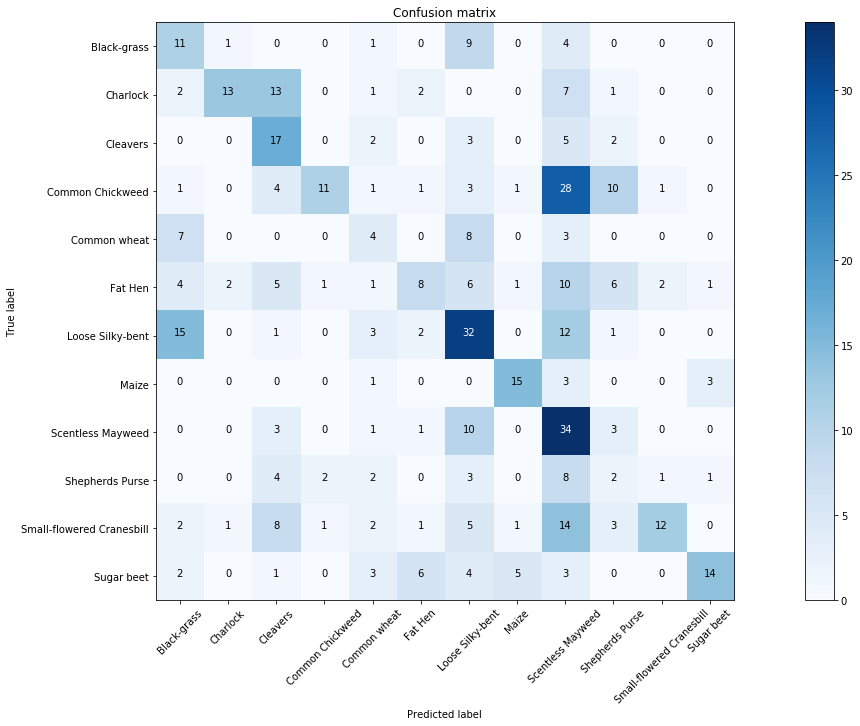

In [48]:
predict(model_Xception,model_name="Xception")

In [70]:
# Fine tuning
"""
.
"""
layer_to_freeze = 126

# IncpetionV3: Transfer Learning
model_Xception = Xception(weights = "imagenet", include_top=False, input_shape = (128, 128, 3))

#freeze layer weight
for layer in model_Xception.layers[:layer_to_freeze]:
    layer.trainable = False

# add FC layers
x = model_Xception.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(12, activation='softmax')(x)
model_Xception = Model(inputs=model_Xception.input, outputs=predictions)
model_Xception.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy',fmeasure]) 

In [72]:
# Xception_fine_history=train(model_Xception_fine,model_name="Xception_fine2",x = X_train_aug_tensor, y = y_train_aug_label, epochs=2)

Test F1 Score: 0.47875
Test Accuracy Score: 0.48000


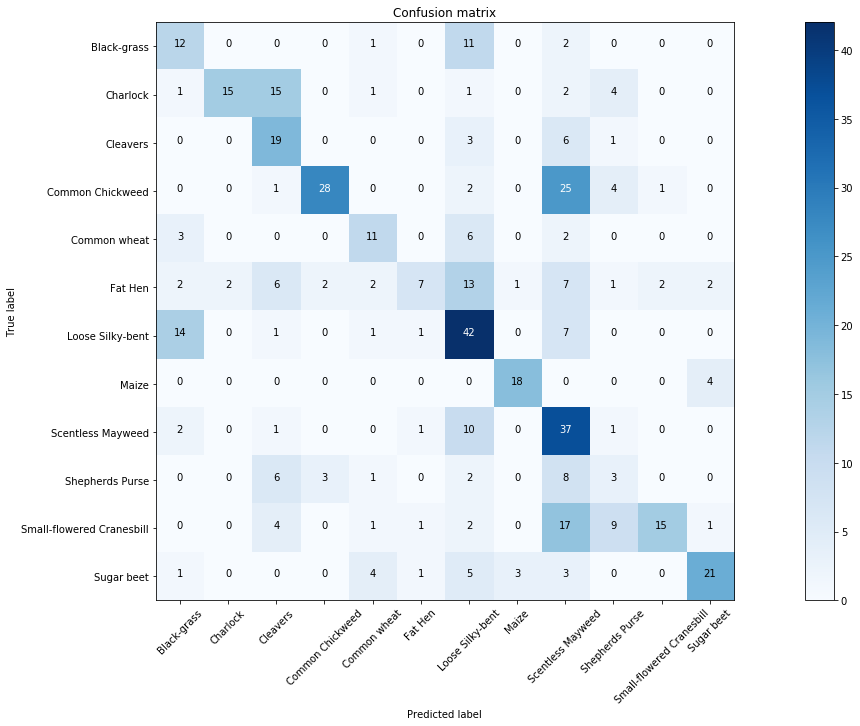

In [69]:
predict(model_Xception,model_name="Xception_fine")

In [24]:
#function to load datasets.
def load_dataset(path):
    data = load_files(path)
    X_files = np.array(data['filenames'])
    y_target= np.array(data['target'])
    labels= np.array(data['target_names'])
#     targets = np_utils.to_categorical(np.array(data['target']), 12)
    return X_files,y_target,labels

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (128, 128 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 128, 128, 3) and return 4D tensor
    return np.expand_dims(x, axis=0).astype('float32')/255

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

# Loading dataset: Files Path and Target class
X, y,labels = load_dataset(train_dir)

# Convert Images into 4D Tensor suitable for a Keras CNN
train_tensors = paths_to_tensor(X)
train_labels = y


# Stratified Sampling: Split data in 80% training and 20% for validation and test.
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)     

for train_index, test_index in sss.split(train_tensors, train_labels):
    X_train, X_temp = train_tensors[train_index], train_tensors[test_index]
    y_train, y_temp = train_labels[train_index], train_labels[test_index]

# Split 20% data in validation and Test set
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for train_index, test_index in sss2.split(X_temp, y_temp):
    X_valid, X_test = X_temp[train_index], X_temp[test_index]
    y_valid, y_test = y_temp[train_index], y_temp[test_index]


#One hot encoding of labels.
y_train_label = np_utils.to_categorical(y_train, 12)
y_valid_label = np_utils.to_categorical(y_valid, 12)
y_test_label = np_utils.to_categorical(y_test, 12)


[]


(0,)

In [85]:
X_valid.shape

(475, 224, 224, 3)

100%|██████████| 7200/7200 [00:10<00:00, 671.22it/s]


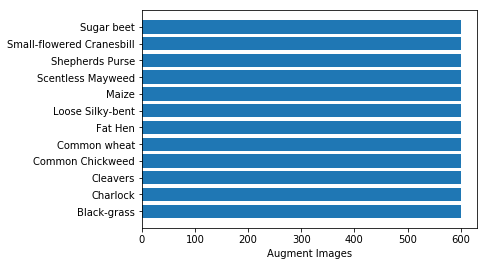

In [75]:
# augment_imgs(X_train, y_train, labels)
# Prepare Augment images for Keras
X_train_aug, y_train_aug,labels_aug = load_dataset('augment2')

#Convert to tensor
X_train_aug_tensor = paths_to_tensor(X_train_aug)

# One hot encoding of labels
y_train_aug_label = np_utils.to_categorical(y_train_aug, 12)

label_dist(y_train_aug_label, 'Augment Images', labels_aug)

In [81]:
y_train_aug_label.shape

(7200, 12)

In [78]:
# Fine tuning Inception
"""
.
"""
layer_to_freeze = 235

# IncpetionV3: Transfer Learning
model_InceptionV3 = InceptionV3(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))

#freeze layer weight
for layer in model_InceptionV3.layers[:layer_to_freeze]:
    layer.trainable = False

# add FC layers
x = model_InceptionV3.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(12, activation='softmax')(x)
model_InceptionV3 = Model(inputs=model_InceptionV3.input, outputs=predictions)
model_InceptionV3.compile(optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy',fmeasure]) 

In [77]:
for i, layer in enumerate(model_InceptionV3.layers):
    print(i, layer.name)

0 input_20
1 conv2d_77
2 batch_normalization_77
3 activation_1
4 conv2d_78
5 batch_normalization_78
6 activation_2
7 conv2d_79
8 batch_normalization_79
9 activation_3
10 max_pooling2d_1
11 conv2d_80
12 batch_normalization_80
13 activation_4
14 conv2d_81
15 batch_normalization_81
16 activation_5
17 max_pooling2d_2
18 conv2d_85
19 batch_normalization_85
20 activation_9
21 conv2d_83
22 conv2d_86
23 batch_normalization_83
24 batch_normalization_86
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_82
29 conv2d_84
30 conv2d_87
31 conv2d_88
32 batch_normalization_82
33 batch_normalization_84
34 batch_normalization_87
35 batch_normalization_88
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_92
42 batch_normalization_92
43 activation_16
44 conv2d_90
45 conv2d_93
46 batch_normalization_90
47 batch_normalization_93
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_89
52 conv2d_91
53 conv2d_94
54 conv2d_95
55 batch_normalizatio

In [89]:
InceptionV3_history=train(model_InceptionV3,model_name="InceptionV3_fine",x = X_train_aug_tensor, y = y_train_aug_label, epochs=5)

Train on 7200 samples, validate on 475 samples
Epoch 1/5
7200/7200 [==============================] - 75s - loss: 0.1155 - acc: 0.9788 - fmeasure: 0.9742 - val_loss: 0.6937 - val_acc: 0.7516 - val_fmeasure: 0.7487
Epoch 2/5
7200/7200 [==============================] - 74s - loss: 0.1085 - acc: 0.9797 - fmeasure: 0.9774 - val_loss: 0.6968 - val_acc: 0.7495 - val_fmeasure: 0.7557
Epoch 3/5
7200/7200 [==============================] - 75s - loss: 0.1034 - acc: 0.9824 - fmeasure: 0.9790 - val_loss: 0.6903 - val_acc: 0.7600 - val_fmeasure: 0.7584
Epoch 4/5
7200/7200 [==============================] - 74s - loss: 0.1004 - acc: 0.9818 - fmeasure: 0.9796 - val_loss: 0.6963 - val_acc: 0.7516 - val_fmeasure: 0.7544
Epoch 5/5
7200/7200 [==============================] - 75s - loss: 0.0997 - acc: 0.9829 - fmeasure: 0.9813 - val_loss: 0.6841 - val_acc: 0.7558 - val_fmeasure: 0.7594


Test F1 Score: 0.76124
Test Accuracy Score: 0.75368


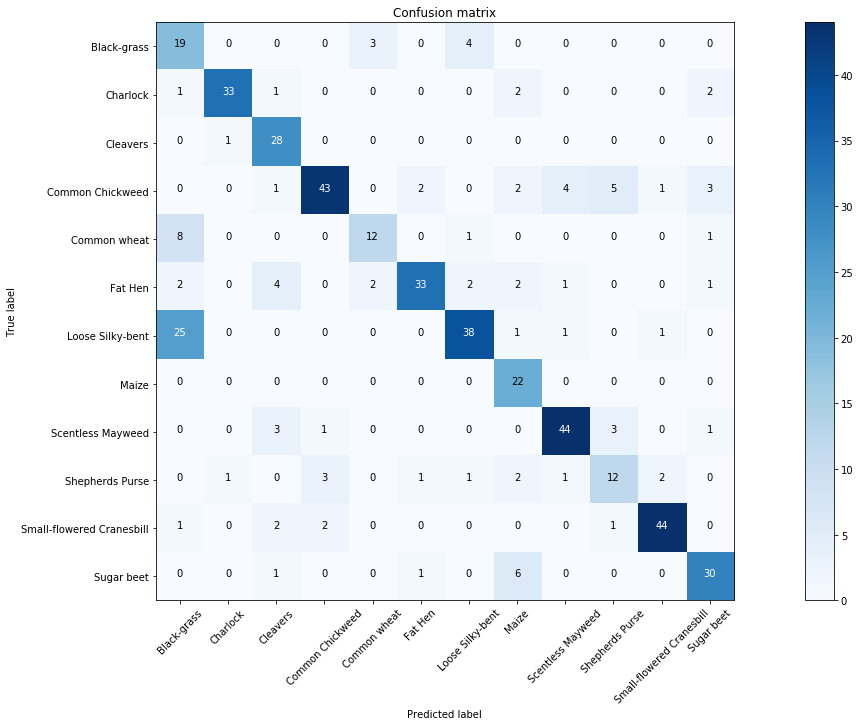

In [90]:
predict(model_InceptionV3,model_name="InceptionV3_fine")

In [27]:
#Change architect by introducting additional Conv layer before max pooling.
#Model Name in Report : Wide2_Extra_Conv

model9_Aug3=Sequential()
#Conv Layer 1
model9_Aug3.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding='same', input_shape=(128, 128, 3)))
model9_Aug3.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding='same'))
model9_Aug3.add(MaxPooling2D(pool_size=(3, 3)))
model9_Aug3.add(Dropout(0.2))

#Conv Layer 2
model9_Aug3.add(Conv2D(128, kernel_size=(3, 3),padding='same', activation='relu' ))
model9_Aug3.add(Conv2D(128, kernel_size=(3, 3),padding='same', activation='relu' ))
model9_Aug3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model9_Aug3.add(Dropout(0.2))

#Conv Layer 3
model9_Aug3.add(Conv2D(128, kernel_size=(3, 3),padding='same', activation='relu'))
model9_Aug3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model9_Aug3.add(Dropout(0.2))

#Conv Layer 4
model9_Aug3.add(Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu'))
model9_Aug3.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model9_Aug3.add(GlobalAveragePooling2D())

#Dense Layer 
model9_Aug3.add(Dense(512, activation='relu'))
model9_Aug3.add(Dropout(0.4))

#Dense Layer 
model9_Aug3.add(Dense(256, activation='relu'))
model9_Aug3.add(Dropout(0.4))

model9_Aug3.add(Dense(12, activation='softmax'))
model9_Aug3.summary()
# Dense layer added
model9_Aug3.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy',fmeasure])
model9_Aug3_history=train(model9_Aug3,model_name="Wide2_Extra_Conv_Aug",x = X_train_aug_tensor, y = y_train_aug_label, epochs=25)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 128, 64)      1792      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 42, 42, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 42, 42, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 42, 42, 128)       73856     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 42, 42, 128)       147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 21, 21, 128)       0         
__________

Test F1 Score: 0.85655
Test Accuracy Score: 0.85474


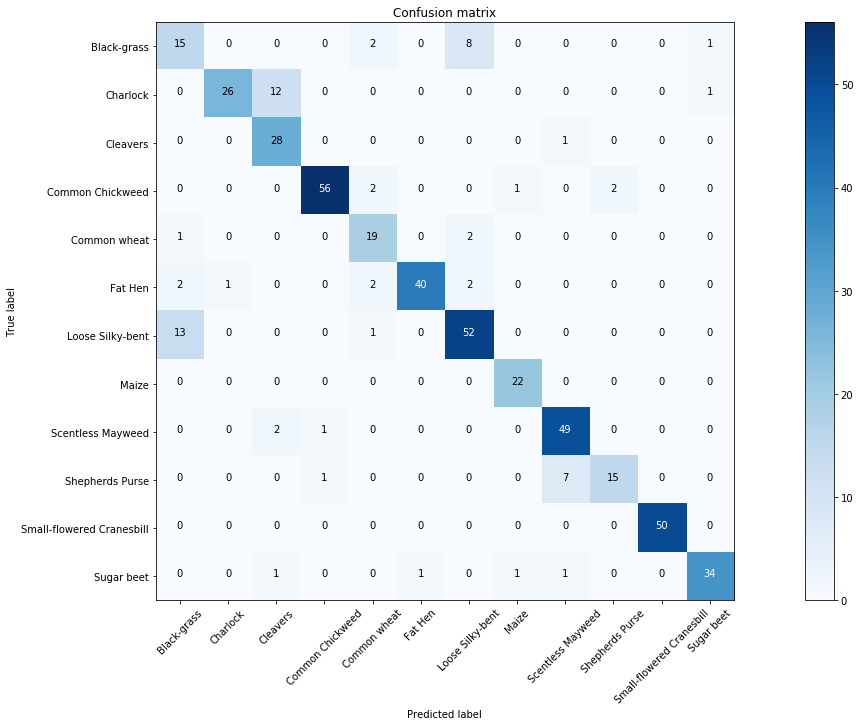

In [28]:
predict(model9_Aug3,model_name="Wide2_Extra_Conv_Aug")

In [29]:
# Model Name: Wide2Dense
# Added more nodes to fullyconnected layers

model5_Aug1k=Sequential()
#Conv Layer 1
model5_Aug1k.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding='same', input_shape=(128, 128, 3)))
model5_Aug1k.add(MaxPooling2D(pool_size=(3, 3)))
model5_Aug1k.add(Dropout(0.2))

#Conv Layer 2
model5_Aug1k.add(Conv2D(128, kernel_size=(3, 3),padding='same', activation='relu' ))
model5_Aug1k.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model5_Aug1k.add(Dropout(0.2))

#Conv Layer 3
model5_Aug1k.add(Conv2D(128, kernel_size=(3, 3),padding='same', activation='relu'))
model5_Aug1k.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model5_Aug1k.add(Dropout(0.2))

#Conv Layer 4
model5_Aug1k.add(Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu'))
model5_Aug1k.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model5_Aug1k.add(GlobalAveragePooling2D())

#Dense Layers
model5_Aug1k.add(Dense(1024, activation='relu'))
model5_Aug1k.add(Dropout(0.2))

#Dense Layer 2
model5_Aug1k.add(Dense(512, activation='relu'))
model5_Aug1k.add(Dropout(0.2))

model5_Aug1k.add(Dense(12, activation='softmax'))
model5_Aug1k.summary()
# Dense layer added
model5_Aug1k.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy',fmeasure])
model5_Aug1k_history=train(model5_Aug1k,model_name="Wide2_Aug1K",x = X_train_aug_tensor, y = y_train_aug_label, epochs=20)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 42, 42, 64)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 42, 42, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 42, 42, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 21, 21, 128)       0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 21, 21, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 21, 21, 128)       147584    
__________

Test F1 Score: 0.85355
Test Accuracy Score: 0.85263


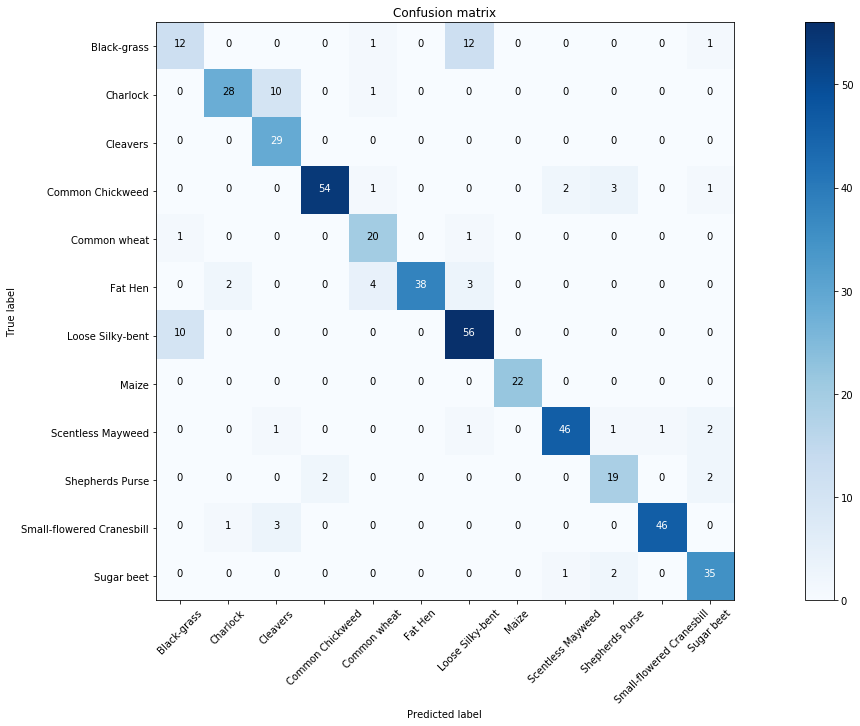

In [30]:
predict(model5_Aug1k,model_name="Wide2_Aug1K")

In [33]:
#function to load datasets.
import glob
K_files = glob.glob("./test/*")

K_test_tensor=paths_to_tensor(K_files)

100%|██████████| 794/794 [00:04<00:00, 185.43it/s]


In [42]:
#Load best model weights
model5_Aug1k.load_weights('./weights/weights.from_Wide2_Aug1K.hdf5')

#predict on Kaggle test data
predictions = [np.argmax(model5_Aug1k.predict(np.expand_dims(feature, axis=0))) 
               for feature in K_test_tensor]

#save file
file_names = [x[7:] for x in K_files]
df = pd.DataFrame(data={'file': file_names, 'species': labels[predictions]})
df.to_csv("kaggle/predictions_%s.csv" % "Wide2_Aug1K", index=False)
